In [2]:
!pip install opendatasets --quiet
import opendatasets as od
od.download('https://www.kaggle.com/datasets/andrewmvd/animal-faces')


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

Abort: 

In [1]:
import torch
from torch import nn
from torch.optim import Adam
from torchvision.transforms import transforms
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset , DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from PIL import Image
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


cuda


In [4]:
image_pate = []
labels = []
base = '/kaggle/input/animal-faces/afhq'
for i in os.listdir(f'{base}'):
  print(i)
  for label in os.listdir(f'{base}/{i}'):
    for image in os.listdir(f'{base}/{i}/{label}'):
      image_pate.append(f'{base}/{i}/{label}/{image}')
      labels.append(label)

data_df = pd.DataFrame(zip(image_pate,labels),columns = ['image_path','labels'])
data_df.head()

val
train


,image_path,labels
0,/kaggle/input/animal-faces/afhq/val/dog/flickr...,dog
1,/kaggle/input/animal-faces/afhq/val/dog/pixaba...,dog
2,/kaggle/input/animal-faces/afhq/val/dog/flickr...,dog
3,/kaggle/input/animal-faces/afhq/val/dog/flickr...,dog
4,/kaggle/input/animal-faces/afhq/val/dog/pixaba...,dog


In [5]:
print(data_df['labels'].unique())

['dog' 'wild' 'cat']


In [6]:
train = data_df.sample(frac=0.7)
test = data_df.drop(train.index)

val = test.sample(frac=0.5)
test = test.drop(val.index)

print(train.shape)
print(val.shape)
print(test.shape)

(11291, 2)
(2420, 2)
(2419, 2)


In [7]:
label_encoder = LabelEncoder()
label_encoder.fit(data_df['labels'])

transforms = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

In [12]:
class CustomImageDataset(Dataset):
  def __init__(self,dataframe,transforms = None):
    self.dataframe = dataframe
    self.transforms = transforms
    self.labels = torch.tensor(label_encoder.transform(dataframe['labels'])).to(device)

  def __len__(self):
    return self.dataframe.shape[0]

  def __getitem__(self,idx):
    image_path = self.dataframe.iloc[idx,0]
    label = self.labels[idx]

    image = Image.open(image_path).convert('RGB')

    if self.transforms:
      image = self.transforms(image).to(device)

    return image , label

In [13]:
train_dataset = CustomImageDataset(dataframe = train,transforms= transforms)
val_dataset = CustomImageDataset(dataframe = val,transforms= transforms)
test_dataset = CustomImageDataset(dataframe = test,transforms= transforms)

In [14]:
train_dataset.__getitem__(1)

(tensor([[[0.7137, 0.7137, 0.7176,  ..., 0.7608, 0.7608, 0.7686],
          [0.7216, 0.7216, 0.7176,  ..., 0.7608, 0.7608, 0.7686],
          [0.7176, 0.7176, 0.7176,  ..., 0.7647, 0.7686, 0.7725],
          ...,
          [0.4314, 0.4275, 0.4314,  ..., 0.4980, 0.3608, 0.3137],
          [0.4353, 0.4275, 0.4314,  ..., 0.4627, 0.3961, 0.4000],
          [0.4353, 0.4275, 0.4314,  ..., 0.5961, 0.4157, 0.3882]],
 
         [[0.7451, 0.7451, 0.7490,  ..., 0.7882, 0.7882, 0.7961],
          [0.7529, 0.7529, 0.7490,  ..., 0.7882, 0.7882, 0.7961],
          [0.7490, 0.7490, 0.7490,  ..., 0.7922, 0.7961, 0.8000],
          ...,
          [0.4471, 0.4431, 0.4471,  ..., 0.4941, 0.3569, 0.3059],
          [0.4510, 0.4431, 0.4471,  ..., 0.4588, 0.3922, 0.3922],
          [0.4510, 0.4431, 0.4471,  ..., 0.5922, 0.4118, 0.3843]],
 
         [[0.4431, 0.4431, 0.4471,  ..., 0.4824, 0.4824, 0.4902],
          [0.4510, 0.4510, 0.4471,  ..., 0.4824, 0.4824, 0.4902],
          [0.4471, 0.4471, 0.4471,  ...,

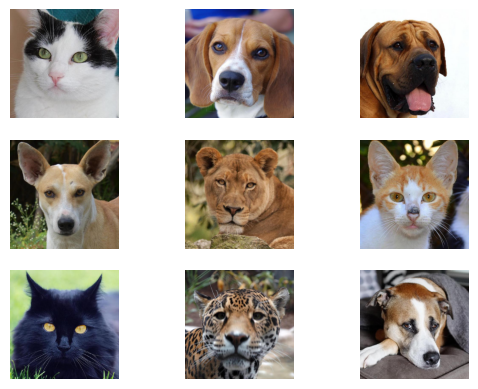

In [15]:
n_rows = 3
n_cols = 3

f, axarr = plt.subplots(n_rows,n_cols)

for row in range(n_rows):
  for col in range(n_cols):
    image = Image.open(data_df.sample(n=1)['image_path'].iloc[0]).convert('RGB')
    axarr[row,col].imshow(image)
    axarr[row,col].axis('off')

plt.show()

In [16]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 10

In [17]:
train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(3,32,kernel_size=3 , padding=1)
    self.conv2 = nn.Conv2d(32,64, kernel_size=3 , padding=1)
    self.conv3 = nn.Conv2d(64,128,kernel_size=3 , padding=1)

    self.pooling = nn.MaxPool2d(2,2)

    self.relu = nn.ReLU()

    self.flatten = nn.Flatten()

    self.linear = nn.Linear((128*16*16),128)

    self.output = nn.Linear(128,len(data_df['labels'].unique()))
  def forward(self,x):
    x = self.conv1(x) # --> (32, 128, 128)
    x = self.pooling(x) # --> (32, 64, 64)
    x = self.relu(x)

    x = self.conv2(x) # --> (64, 64, 64)
    x = self.pooling(x) # --> (64, 32,32)
    x = self.relu(x)

    x = self.conv3(x) # --> (128,64,64)
    x = self.pooling(x) # --> (128,16,16)
    x = self.relu(x)

    x = self.flatten(x)
    x = self.linear(x)
    x = self.output(x)
    return x

In [19]:
model = Net().to(device)

In [20]:
from torchsummary import summary
summary(model,input_size=(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(),lr = LR)

In [23]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0
  total_loss_val = 0
  total_acc_val = 0

  for inputs , labels in train_loader:
    optimizer.zero_grad()

    outputs = model(inputs)
    train_loss = criterion(outputs,labels)
    total_loss_train += train_loss.item()

    train_loss.backward()

    train_acc = (torch.argmax(outputs,axis=1) == labels).sum().item()
    # print(torch.argmax(outputs,axis=1) == labels) # tensor([ True,  True,  True, False,  True,  True, False, False, False, False, True, False,  True, False, False,  True])
    # print((torch.argmax(outputs,axis=1) == labels).sum().item()) # 8

    total_acc_train += train_acc
    optimizer.step()

  with torch.no_grad():
    for inputs , labels in val_loader:
      outputs = model(inputs)
      val_loss = criterion(outputs,labels)
      total_loss_val += val_loss.item()

      val_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()

      total_acc_val += val_acc

  total_loss_train_plot.append(round(total_loss_train/1000,4))
  total_loss_validation_plot.append(round(total_loss_val/1000,4))

  total_acc_train_plot.append(round((total_acc_train/train_dataset.__len__())*100,4))
  total_acc_validation_plot.append(round((total_acc_val/val_dataset.__len__())*100,4))

  print(f'''Epoch {epoch+1}/{EPOCHS} , Train Loss : {round(total_loss_train/1000,4)} , Train Accuracy : {round((total_acc_train/train_dataset.__len__())*100,4)}
            Val Loss : {round(total_loss_val/1000,4)} , Val Accuracy : {round((total_acc_val/val_dataset.__len__())*100,4)}

  ''')

Epoch 1/10 , Train Loss : 0.3248 , Train Accuracy : 81.038
            Val Loss : 0.0468 , Val Accuracy : 88.9669

  
Epoch 2/10 , Train Loss : 0.1392 , Train Accuracy : 92.7464
            Val Loss : 0.0272 , Val Accuracy : 93.2231

  
Epoch 3/10 , Train Loss : 0.0894 , Train Accuracy : 95.4211
            Val Loss : 0.0228 , Val Accuracy : 93.843

  
Epoch 4/10 , Train Loss : 0.0611 , Train Accuracy : 96.9002
            Val Loss : 0.0211 , Val Accuracy : 94.7521

  
Epoch 5/10 , Train Loss : 0.045 , Train Accuracy : 97.8036
            Val Loss : 0.0178 , Val Accuracy : 95.2479

  
Epoch 6/10 , Train Loss : 0.0345 , Train Accuracy : 98.211
            Val Loss : 0.0161 , Val Accuracy : 96.157

  
Epoch 7/10 , Train Loss : 0.0238 , Train Accuracy : 98.8221
            Val Loss : 0.0165 , Val Accuracy : 96.4876

  
Epoch 8/10 , Train Loss : 0.0157 , Train Accuracy : 99.318
            Val Loss : 0.0158 , Val Accuracy : 97.1074

  
Epoch 9/10 , Train Loss : 0.0141 , Train Accuracy : 99

In [25]:
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0
    for inputs, labels in test_loader:
        prediction = model(inputs)

        acc = (torch.argmax(prediction , axis=1) == labels).sum().item()
        total_acc_test += acc
        test_loss = criterion(prediction,labels)
        total_loss_test += test_loss.item()
        
print(f"Accuracy Score is : {round((total_acc_test/test_dataset.__len__())*100,4)} Loss Score is : {round(total_loss_test/1000,4)}")

Accuracy Score is : 96.0728 Loss Score is : 0.0211


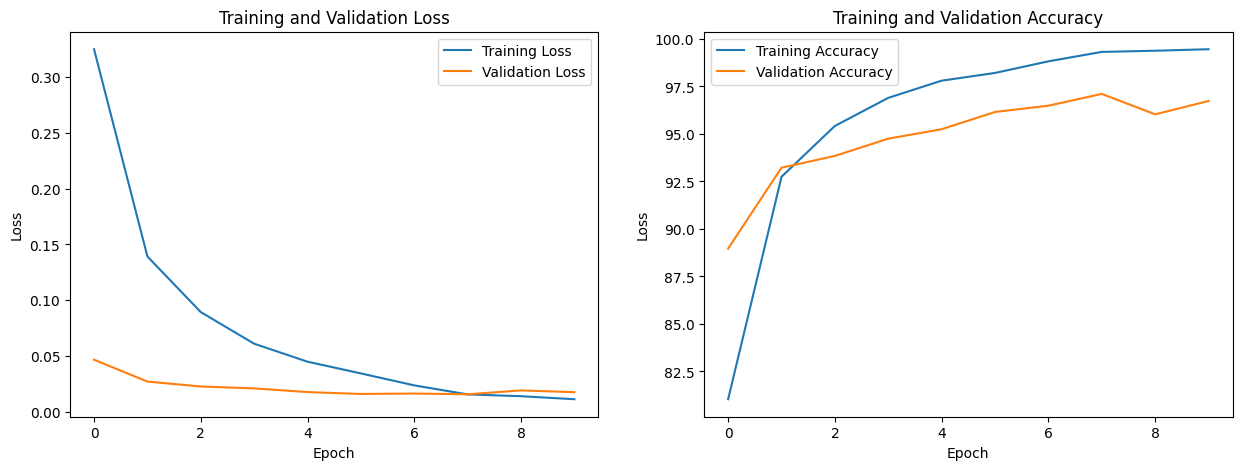

In [31]:
fig , axs = plt.subplots(nrows=1,ncols=2,figsize= (15,5))

axs[0].plot(total_loss_train_plot,label = "Training Loss")
axs[0].plot(total_loss_validation_plot,label = "Validation Loss")
axs[0].set_title("Training and Validation Loss")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(total_acc_train_plot,label = "Training Accuracy")
axs[1].plot(total_acc_validation_plot,label = "Validation Accuracy")
axs[1].set_title("Training and Validation Accuracy")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.show()

In [41]:
def predict_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transforms(image).to(device)

    output = model(image.unsqueeze(0))

    output = torch.argmax(output,axis=1).item()

    return label_encoder.inverse_transform([output])

In [42]:
predict_image('/kaggle/input/animal-faces/afhq/val/wild/flickr_wild_000004.jpg')

array(['wild'], dtype=object)